**Import Library**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [ ]:
df = pd.read_csv("/content/restaurant_customer_satisfaction.csv")
print("Preview Dataset:")
print(df.head())
print(f"\nShape: {df.shape}")

Preview Dataset:
   CustomerID  Age  Gender  Income VisitFrequency  AverageSpend  \
0         654   35    Male   83380         Weekly     27.829142   
1         655   19    Male   43623         Rarely    115.408622   
2         656   41  Female   83737         Weekly    106.693771   
3         657   43    Male   96768         Rarely     43.508508   
4         658   55  Female   67937        Monthly    148.084627   

  PreferredCuisine TimeOfVisit  GroupSize DiningOccasion  MealType  \
0          Chinese   Breakfast          3       Business  Takeaway   
1         American      Dinner          1         Casual   Dine-in   
2         American      Dinner          6    Celebration   Dine-in   
3           Indian       Lunch          1    Celebration   Dine-in   
4          Chinese   Breakfast          1       Business  Takeaway   

   OnlineReservation  DeliveryOrder  LoyaltyProgramMember   WaitTime  \
0                  0              1                     1  43.523929   
1              

**Data Cleaning & Handling Missing Values**

In [ ]:
print("\n=== Pengecekan Nilai Hilang Awal ===")
print(df.isnull().sum())
print("-" * 50)

# Kolom kategorikal diisi dengan modus
cols_mode = ['Gender', 'TimeOfVisit', 'DiningOccasion', 'MealType', 'PreferredCuisine']
for col in cols_mode:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"{col}: Diisi dengan modus = {mode_val}")

# Kolom numerik diisi dengan median
cols_median = ['Income', 'AverageSpend', 'WaitTime']
for col in cols_median:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"{col}: Diisi dengan median = {median_val:.2f}")

print("\n=== Setelah Handling Missing Values ===")
print(df.isnull().sum().sum(), "nilai hilang tersisa")

label_encoders = {}
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

print(f"\n{len(label_encoders)} kolom kategorikal diencode: {list(label_encoders.keys())}")

if "CustomerID" in df.columns:
    df = df.drop("CustomerID", axis=1)
    print("CustomerID dihapus")



=== Pengecekan Nilai Hilang Awal ===
CustomerID              0
Age                     0
Gender                  0
Income                  0
VisitFrequency          0
AverageSpend            0
PreferredCuisine        0
TimeOfVisit             0
GroupSize               0
DiningOccasion          0
MealType                0
OnlineReservation       0
DeliveryOrder           0
LoyaltyProgramMember    0
WaitTime                0
ServiceRating           0
FoodRating              0
AmbianceRating          0
HighSatisfaction        0
dtype: int64
--------------------------------------------------

=== Setelah Handling Missing Values ===
0 nilai hilang tersisa

6 kolom kategorikal diencode: ['Gender', 'VisitFrequency', 'PreferredCuisine', 'TimeOfVisit', 'DiningOccasion', 'MealType']
CustomerID dihapus


**Rekayasa Fitur Baru**

In [ ]:
print("\n=== Rekayasa Fitur Lanjutan ===")

# Rating-based features
df['TotalRating'] = df['ServiceRating'] + df['FoodRating'] + df['AmbianceRating']
df['AvgRating'] = df['TotalRating'] / 3
df['RatingStd'] = df[['ServiceRating', 'FoodRating', 'AmbianceRating']].std(axis=1)
df['MaxRating'] = df[['ServiceRating', 'FoodRating', 'AmbianceRating']].max(axis=1)
df['MinRating'] = df[['ServiceRating', 'FoodRating', 'AmbianceRating']].min(axis=1)
df['RatingRange'] = df['MaxRating'] - df['MinRating']

# Spending features
df['SpendPerPerson'] = df['AverageSpend'] / (df['GroupSize'] + 1)
df['SpendToIncomeRatio'] = df['AverageSpend'] / (df['Income'] + 1)
df['HighSpender'] = (df['AverageSpend'] > df['AverageSpend'].quantile(0.75)).astype(int)

# Wait time features
df['LongWait'] = (df['WaitTime'] > df['WaitTime'].quantile(0.75)).astype(int)
df['WaitToService'] = df['WaitTime'] / (df['ServiceRating'] + 1)

# Customer profile features
df['HighIncome'] = (df['Income'] > df['Income'].median()).astype(int)
df['FrequentVisitor'] = (df['VisitFrequency'] >= df['VisitFrequency'].median()).astype(int)
df['LoyalCustomer'] = df['LoyaltyProgramMember']
df['OnlineUser'] = df['OnlineReservation']

# Age-based features
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)
df['YoungCustomer'] = (df['Age'] < 30).astype(int)
df['SeniorCustomer'] = (df['Age'] > 55).astype(int)

# Interaction features
df['Rating_x_Loyalty'] = df['AvgRating'] * df['LoyaltyProgramMember']
df['Rating_x_Frequency'] = df['AvgRating'] * df['VisitFrequency']
df['Wait_x_Service'] = df['WaitTime'] * (6 - df['ServiceRating'])
df['Spend_x_Rating'] = df['AverageSpend'] * df['AvgRating']

# Group dynamics
df['LargeGroup'] = (df['GroupSize'] > 3).astype(int)
df['Solo'] = (df['GroupSize'] == 1).astype(int)

# Quality consistency indicator
df['ConsistentQuality'] = (df['RatingStd'] < 0.5).astype(int)

print(f"Total fitur setelah rekayasa: {df.shape[1]}")
print(f"Fitur baru dibuat: {df.shape[1] - 17}")


=== Rekayasa Fitur Lanjutan ===
Total fitur setelah rekayasa: 43
Fitur baru dibuat: 26


**Persiapan Data (Splitting)**

In [ ]:
X = df.drop("HighSatisfaction", axis=1)
y = df["HighSatisfaction"]

print(f"\nDistribusi Target Variable:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Training: {X_train.shape}")
print(f"Data Testing: {X_test.shape}")


Distribusi Target Variable:
HighSatisfaction
0    0.866
1    0.134
Name: proportion, dtype: float64

Data Training: (1200, 42)
Data Testing: (300, 42)


**Handling Imbalanced Data**

In [ ]:
print("\n" + "="*70)
print("IMPROVED IMBALANCED DATA HANDLING")
print("="*70)

np.random.seed(42)

# Lebih aggressive oversampling
X_train_minority = X_train[y_train == 1].copy()
y_train_minority = y_train[y_train == 1].copy()
X_train_majority = X_train[y_train == 0].copy()
y_train_majority = y_train[y_train == 0].copy()

n_minority = len(X_train_minority)
n_majority = len(X_train_majority)
oversample_ratio = 1.0

n_samples_needed = int(n_majority * oversample_ratio) - n_minority

if n_samples_needed > 0:
    synthetic_samples = []

    for _ in range(n_samples_needed):
        idx = np.random.choice(X_train_minority.index)
        sample = X_train_minority.loc[idx].copy()

        # Add noise dengan variasi lebih besar
        numeric_cols = X_train_minority.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            noise = np.random.normal(0, 0.08 * sample[col])
            sample[col] += noise

        synthetic_samples.append(sample)

    X_minority_oversampled = pd.DataFrame(synthetic_samples)
    y_minority_oversampled = pd.Series([1] * n_samples_needed)

    X_train_balanced = pd.concat([X_train_majority, X_train_minority, X_minority_oversampled])
    y_train_balanced = pd.concat([y_train_majority, y_train_minority, y_minority_oversampled])

    shuffle_idx = np.random.permutation(len(X_train_balanced))
    X_train_balanced = X_train_balanced.iloc[shuffle_idx].reset_index(drop=True)
    y_train_balanced = y_train_balanced.iloc[shuffle_idx].reset_index(drop=True)
else:
    X_train_balanced = X_train.copy()
    y_train_balanced = y_train.copy()

print(f"Training set setelah oversampling: {X_train_balanced.shape}")
print(f"Kelas 1: {y_train_balanced.sum()} ({y_train_balanced.sum()/len(y_train_balanced)*100:.1f}%)")
print(f"Distribusi:\n{pd.Series(y_train_balanced).value_counts(normalize=True)}")


IMPROVED IMBALANCED DATA HANDLING
Training set setelah oversampling: (2078, 42)
Kelas 1: 1039 (50.0%)
Distribusi:
1    0.5
0    0.5
Name: proportion, dtype: float64


**Scaling & Outliers**

In [ ]:
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

for col in X_train_balanced.columns:
    X_train_balanced[col] = pd.to_numeric(X_train_balanced[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_train_balanced = X_train_balanced.fillna(0)
X_test = X_test.fillna(0)

numeric_cols = ['Age', 'Income', 'AverageSpend', 'WaitTime', 'ServiceRating',
                'FoodRating', 'AmbianceRating', 'TotalRating', 'AvgRating',
                'RatingStd', 'MaxRating', 'MinRating', 'RatingRange',
                'SpendPerPerson', 'SpendToIncomeRatio', 'WaitToService',
                'Rating_x_Loyalty', 'Rating_x_Frequency', 'Wait_x_Service',
                'Spend_x_Rating']

for col in numeric_cols:
    if col not in X_train_balanced.columns:
        continue
    Q1 = X_train_balanced[col].quantile(0.25)
    Q3 = X_train_balanced[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train_balanced[col] = X_train_balanced[col].clip(lower_bound, upper_bound)
    X_test[col] = X_test[col].clip(lower_bound, upper_bound)

scaler = StandardScaler()
X_train_balanced[numeric_cols] = scaler.fit_transform(X_train_balanced[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

**Model Training & Hyperparameter Tuning**

In [ ]:
print("\n" + "="*70)
print("XGBOOST OPTIMIZATION - FOCUS ON MINORITY CLASS")
print("="*70)

scale_pos_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_param_dist = {
    'n_estimators': [400, 600, 800, 1000, 1200],
    'max_depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
    'colsample_bytree': [0.7, 0.75, 0.8, 0.85, 0.9],
    'min_child_weight': [1, 2, 3, 5],
    'gamma': [0, 0.05, 0.1, 0.15, 0.2],
    'reg_alpha': [0.1, 0.5, 1, 5],
    'reg_lambda': [1, 5, 10, 20],
    'max_delta_step': [1, 3, 5, 7]
}

xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    n_jobs=-1
)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_random = RandomizedSearchCV(
    xgb_base,
    xgb_param_dist,
    n_iter=150,
    scoring='f1',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(f"Total fits: {120 * 5} = 600")

xgb_random.fit(X_train_balanced, y_train_balanced)

print(f"\n✓ Best Parameters: {xgb_random.best_params_}")
print(f"✓ Best CV F1-Score: {xgb_random.best_score_:.4f}")

xgb_best = xgb_random.best_estimator_


XGBOOST OPTIMIZATION - FOCUS ON MINORITY CLASS
Scale pos weight: 1.00
Total fits: 600 = 600
Fitting 5 folds for each of 150 candidates, totalling 750 fits

✓ Best Parameters: {'subsample': 0.7, 'reg_lambda': 20, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 9, 'max_delta_step': 1, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.75}
✓ Best CV F1-Score: 0.9595


**Threshold Optimization**

In [ ]:
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Mencari threshold terbaik berdasarkan F1-Score
best_threshold = 0.5
best_f1 = 0
best_metrics = {}

print("\nTesting different thresholds...")
for threshold in np.arange(0.2, 0.6, 0.01):
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {
            'threshold': threshold,
            'f1': f1,
            'accuracy': acc,
            'predictions': y_pred_thresh
        }

    print(f"  Threshold {threshold:.2f}: F1={f1:.4f}, Acc={acc:.4f}")

print(f"\n✓ Best threshold: {best_threshold:.2f}")
print(f"✓ Best F1-Score: {best_f1:.4f}")

# Use optimal threshold
y_pred_optimized = best_metrics['predictions']


THRESHOLD OPTIMIZATION

Testing different thresholds...
  Threshold 0.20: F1=0.5347, Acc=0.8433
  Threshold 0.21: F1=0.5455, Acc=0.8500
  Threshold 0.22: F1=0.5417, Acc=0.8533
  Threshold 0.23: F1=0.5319, Acc=0.8533
  Threshold 0.24: F1=0.5161, Acc=0.8500
  Threshold 0.25: F1=0.5111, Acc=0.8533
  Threshold 0.26: F1=0.5287, Acc=0.8633
  Threshold 0.27: F1=0.5238, Acc=0.8667
  Threshold 0.28: F1=0.5366, Acc=0.8733
  Threshold 0.29: F1=0.5250, Acc=0.8733
  Threshold 0.30: F1=0.5526, Acc=0.8867
  Threshold 0.31: F1=0.5526, Acc=0.8867
  Threshold 0.32: F1=0.5600, Acc=0.8900
  Threshold 0.33: F1=0.5479, Acc=0.8900
  Threshold 0.34: F1=0.5556, Acc=0.8933
  Threshold 0.35: F1=0.5634, Acc=0.8967
  Threshold 0.36: F1=0.5429, Acc=0.8933
  Threshold 0.37: F1=0.5429, Acc=0.8933
  Threshold 0.38: F1=0.5429, Acc=0.8933
  Threshold 0.39: F1=0.5373, Acc=0.8967
  Threshold 0.40: F1=0.5373, Acc=0.8967
  Threshold 0.41: F1=0.5373, Acc=0.8967
  Threshold 0.42: F1=0.5152, Acc=0.8933
  Threshold 0.43: F1=0.

**Evaluasi Model**

In [ ]:
print("\n" + "="*70)
print("FINAL MODEL EVALUATION (OPTIMIZED)")
print("="*70)

accuracy = accuracy_score(y_test, y_pred_optimized)
f1 = f1_score(y_test, y_pred_optimized)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nTEST SET PERFORMANCE:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_optimized,
                          target_names=['Low Satisfaction', 'High Satisfaction']))

cm = confusion_matrix(y_test, y_pred_optimized)
print("\nCONFUSION MATRIX:")
print(f"   True Negatives:  {cm[0, 0]}")
print(f"   False Positives: {cm[0, 1]}")
print(f"   False Negatives: {cm[1, 0]}")
print(f"   True Positives:  {cm[1, 1]}")


FINAL MODEL EVALUATION (OPTIMIZED)

TEST SET PERFORMANCE:
   Accuracy:  0.8967
   F1-Score:  0.5634
   ROC-AUC:   0.7917

CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

 Low Satisfaction       0.93      0.96      0.94       260
High Satisfaction       0.65      0.50      0.56        40

         accuracy                           0.90       300
        macro avg       0.79      0.73      0.75       300
     weighted avg       0.89      0.90      0.89       300


CONFUSION MATRIX:
   True Negatives:  249
   False Positives: 11
   False Negatives: 20
   True Positives:  20


**Visualisasi & Feature Importance**

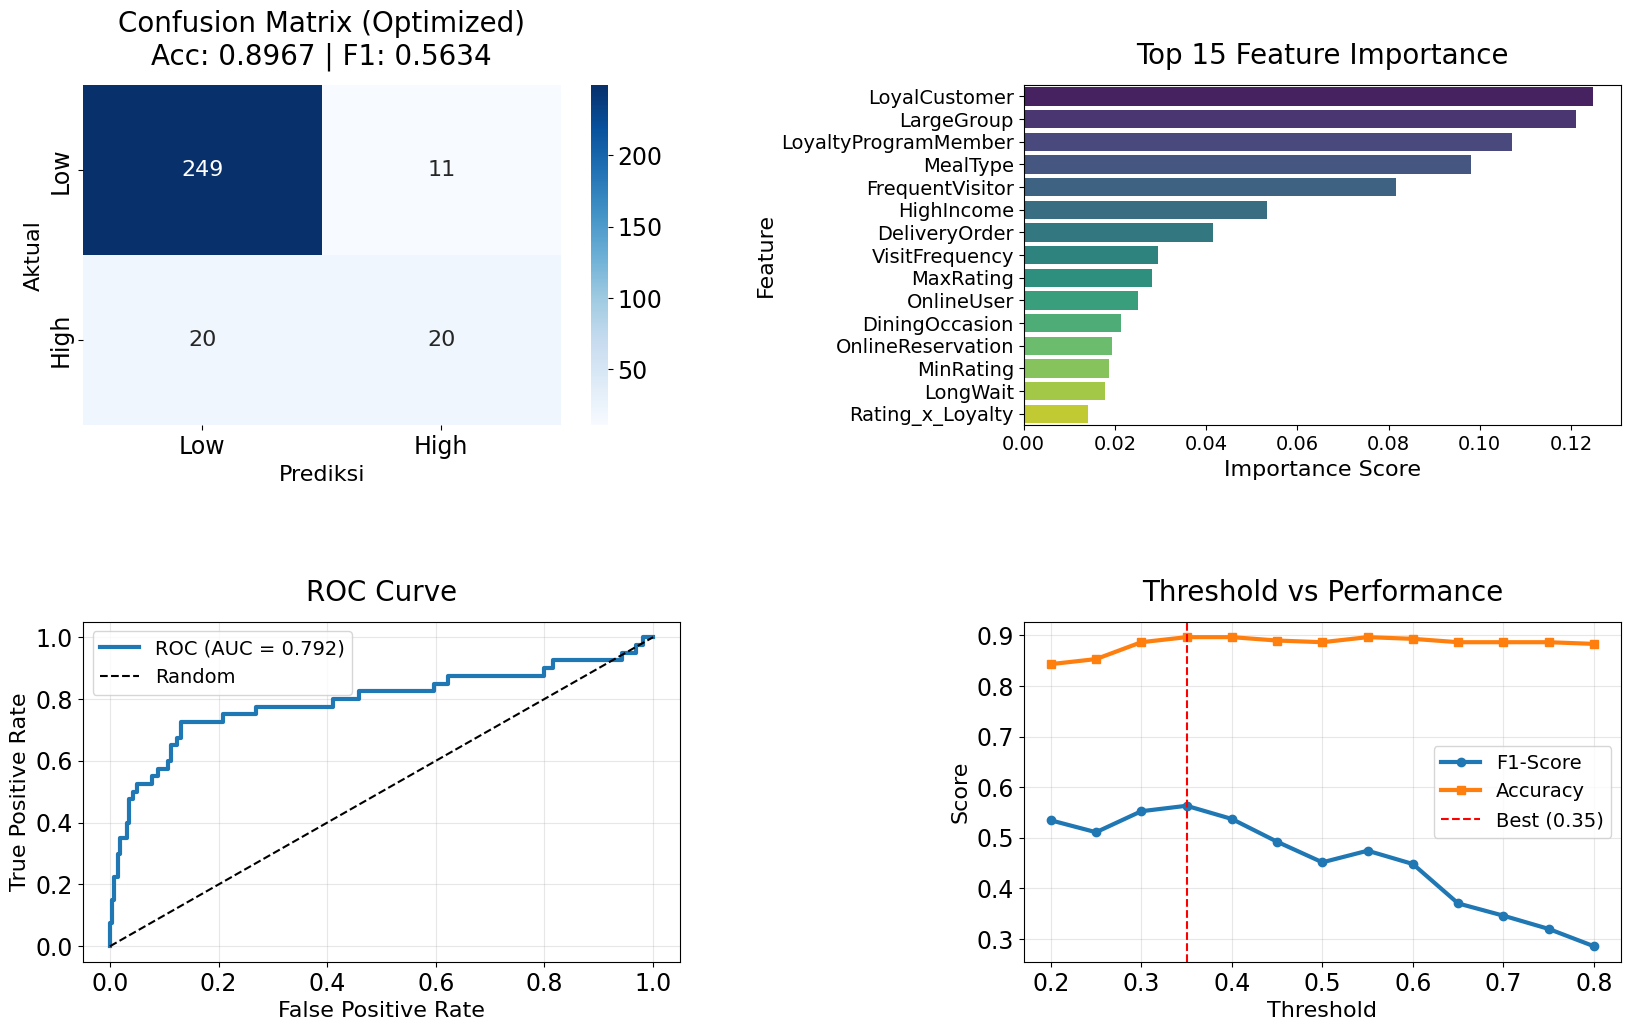

In [74]:
plt.rcParams.update({'font.size': 17}) # Ukuran dasar font

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            annot_kws={"size": 16}, # Ukuran angka di dalam kotak
            xticklabels=['Low', 'High'],
            yticklabels=['Low', 'High'])
axes[0, 0].set_title(f'Confusion Matrix (Optimized)\nAcc: {accuracy:.4f} | F1: {f1:.4f}',
                     fontsize=20, pad=15)
axes[0, 0].set_xlabel('Prediksi', fontsize=16)
axes[0, 0].set_ylabel('Aktual', fontsize=16)

# 2. Feature Importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_importance
}).sort_values(by="Importance", ascending=False).head(15)

sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis", ax=axes[0, 1])
axes[0, 1].set_title("Top 15 Feature Importance", fontsize=20, pad=15)
axes[0, 1].set_xlabel("Importance Score", fontsize=16)
axes[0, 1].set_ylabel("Feature", fontsize=16)
axes[0, 1].tick_params(labelsize=14) # Ukuran nama-nama fitur

# 3. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1, 0].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', linewidth=3)
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=16)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=16)
axes[1, 0].set_title('ROC Curve', fontsize=20, pad=15)
axes[1, 0].legend(fontsize=14)
axes[1, 0].grid(alpha=0.3)

# 4. Threshold Analysis
thresholds = np.arange(0.2, 0.8, 0.05)
f1_scores = []
accuracies = []

for t in thresholds:
    y_p = (y_pred_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_p))
    accuracies.append(accuracy_score(y_test, y_p))

axes[1, 1].plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=3)
axes[1, 1].plot(thresholds, accuracies, 's-', label='Accuracy', linewidth=3)
axes[1, 1].axvline(best_threshold, color='r', linestyle='--', label=f'Best ({best_threshold:.2f})')
axes[1, 1].set_xlabel('Threshold', fontsize=16)
axes[1, 1].set_ylabel('Score', fontsize=16)
axes[1, 1].set_title('Threshold vs Performance', fontsize=20, pad=15)
axes[1, 1].legend(fontsize=14)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout(pad=4.0) # Memberi jarak antar subplots agar tidak tumpang tindih
plt.show()

**Feature Importance Score**

In [ ]:
feature_imp_all = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_importance
}).sort_values(by="Importance", ascending=False)

feature_imp_all.index = range(1, len(feature_imp_all) + 1)
feature_imp_all.index.name = 'No'

print("\n" + "="*36)
print("IMPORTANT FEATURES SCORE ")
print("="*36)
print(feature_imp_all.to_string(index=True))


IMPORTANT FEATURES SCORE 
                 Feature  Importance
No                                  
1          LoyalCustomer    0.124745
2             LargeGroup    0.121190
3   LoyaltyProgramMember    0.106982
4               MealType    0.098159
5        FrequentVisitor    0.081617
6             HighIncome    0.053311
7          DeliveryOrder    0.041546
8         VisitFrequency    0.029369
9              MaxRating    0.028238
10            OnlineUser    0.025019
11        DiningOccasion    0.021261
12     OnlineReservation    0.019302
13             MinRating    0.018687
14              LongWait    0.017748
15      Rating_x_Loyalty    0.014075
16                Gender    0.013775
17                  Solo    0.013373
18            FoodRating    0.012078
19    Rating_x_Frequency    0.011646
20             GroupSize    0.010805
21           TotalRating    0.010381
22         YoungCustomer    0.008835
23         WaitToService    0.008256
24             AvgRating    0.007918
25        W

**Save model**

In [ ]:
filename = 'model_restaurant_xgb.pkl'

# Menyimpan model terbaik
joblib.dump(xgb_best, filename)

print(f"Model berhasil disimpan sebagai {filename}")

Model berhasil disimpan sebagai model_restaurant_xgb.pkl
